In [1]:
import numpy as np
import dapy.filters as filters
from dapy.models import NettoGimenoMendesModel
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 100

## Model

One-dimensional stochastic dynamical system due to Netto et al. [1] with state dynamics defined by discrete time map

\begin{equation}
  x_{t+1} = \alpha x_t + \beta \frac{x_t}{1 + z_t^2} + \gamma \cos(\delta t) + \sigma_x u_t
\end{equation}

with $u_t \sim \mathcal{N}(0, 1) ~\forall t$ and $x_0 \sim \mathcal{N}(m, s^2)$.

Observed process defined by

\begin{equation}
  y_{t} = \epsilon x_t^2 + \sigma_y v_t
\end{equation}

with $v_t \sim \mathcal{N}(0, 1)$.

Standard parameter values assumed here are $\alpha = 0.5$, $\beta = 25$, $\gamma = 8$, $\delta = 1.2$, $\epsilon = 0.05$, $m=10$, $s=5$, $\sigma_x^2 = 1$, $\sigma_y^2 = 1$ and $T = 200$ simulated time steps.

### References

  1. M. L. A. Netto, L. Gimeno, and M. J. Mendes. A new spline algorithm for non-linear filtering of discrete time systems. *Proceedings of the 7th Triennial World Congress*, 1979.

In [2]:
model_params = {
    'initial_state_mean': 10.,
    'initial_state_std': 5.,
    'state_noise_std': 1.,
    'observation_noise_std': 1., 
    'alpha': 0.5,
    'beta': 25.,
    'gamma': 8,
    'delta': 1.2,
    'epsilon': 0.05,
}
model = NettoGimenoMendesModel(**model_params)

## Generate data from model

In [3]:
num_observation_time = 100
observation_time_indices = np.arange(num_observation_time)
seed = 20171027
rng = np.random.default_rng(seed)
state_sequence, observation_sequence = model.sample_state_and_observation_sequences(
    rng, observation_time_indices)

Sampling: 100%|██████████|100/100 [00:00<00:00, 21597.18time-steps/s]

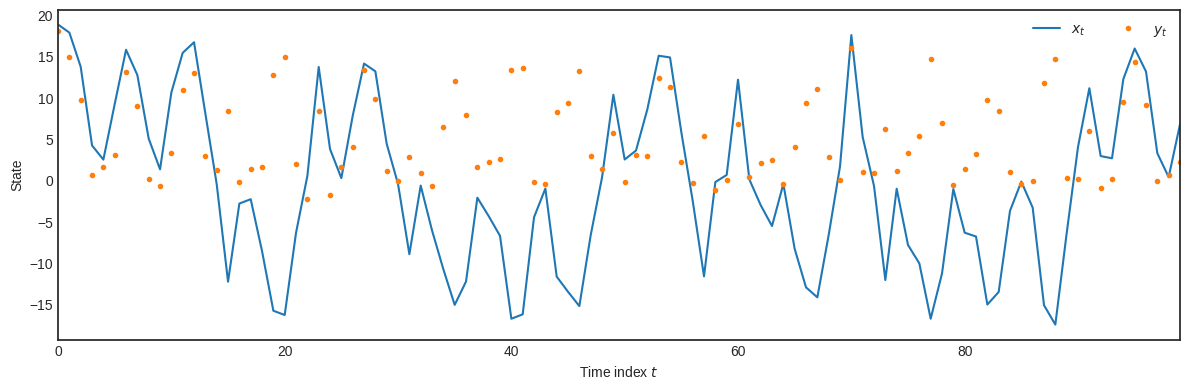

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(observation_time_indices, state_sequence)
ax.plot(observation_time_indices, observation_sequence, '.')
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
_ = ax.set_xlim(0, num_observation_time - 1)
ax.legend(['$x_t$', '$y_t$'], ncol=4)
fig.tight_layout()

## Infer state from observations

In [5]:
def plot_results(results, z_reference=None, plot_traces=True, plot_region=False, 
                 trace_skip=1, trace_alpha=0.25):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
    ax.plot(results['z_mean_seq'][:, 0], 'g-', lw=1)
    if plot_region:
        ax.fill_between(
            np.arange(n_steps),
            results['z_mean_seq'][:, 0] - 3 * results['z_std_seq'][:, 0],
            results['z_mean_seq'][:, 0] + 3 * results['z_std_seq'][:, 0],
            alpha=0.25, color='g'
        )
    if plot_traces:
        ax.plot(results['z_particles_seq'][:, ::trace_skip, 0], 
                'r-', lw=0.25, alpha=trace_alpha)
    if z_reference is not None:
        ax.plot(z_reference[:, 0], 'k--')
    ax.set_ylabel('State $z$')
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, ax

def plot_results(results, observation_time_indices, state_sequence=None, 
                 plot_particles=True, plot_region=False, 
                 particle_skip=5, trace_alpha=0.25):
    fig, ax = plt.subplots(sharex=True, figsize=(12, 4))
    ax.plot(results['state_mean_sequence'][:, 0], 'g-', lw=1, label='Est. mean')
    if plot_region:
        ax.fill_between(
            observation_time_indices,
            results['state_mean_sequence'][:, 0] - 3 * results['state_std_sequence'][:, 0],
            results['state_mean_sequence'][:, 0] + 3 * results['state_std_sequence'][:, 0],
            alpha=0.25, color='g', label='Est. mean ± 3 standard deviation'
        )
    if plot_particles:
        lines = ax.plot(
            observation_time_indices, results['state_particles_sequence'][:, ::particle_skip, 0], 
            'r-', lw=0.25, alpha=trace_alpha)
        lines[0].set_label('Particles')
    if state_sequence is not None:
        ax.plot(observation_time_indices, state_sequence[:, 0], 'k--', label='Truth')
    ax.set_ylabel('$x_t$')
    ax.legend(loc='upper center', ncol=4)
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, ax

### Ensemble Kalman filter (perturbed observations)

In [6]:
enkf = filters.EnsembleKalmanFilter()

In [7]:
results_enkf = enkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=500, rng=rng, return_particles=True)

Filtering: 100%|██████████|100/100 [00:00<00:00, 427.09time-steps/s]

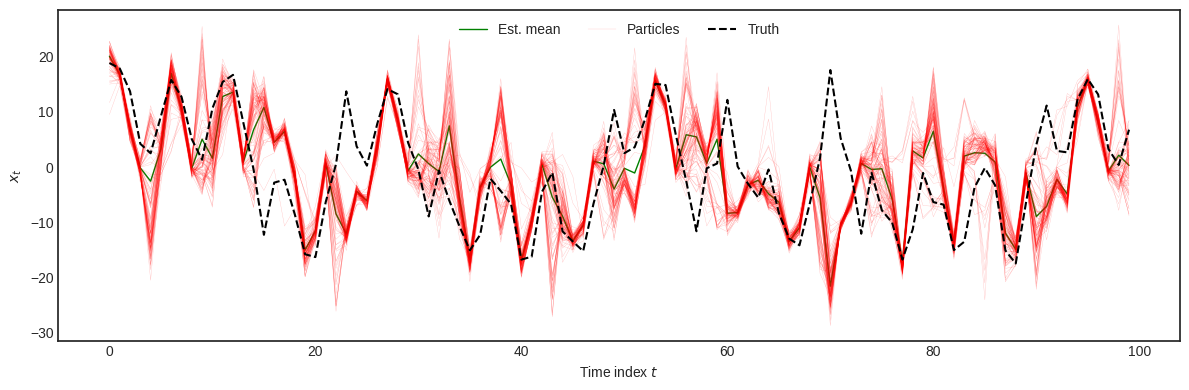

In [8]:
fig, axes = plot_results(results_enkf, observation_time_indices, state_sequence)

### Ensemble Trasform Kalman filter (deterministic square root)

In [9]:
etkf = filters.EnsembleTransformKalmanFilter()

In [10]:
results_etkf = etkf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=500, rng=rng, return_particles=True)

Filtering: 100%|██████████|100/100 [00:00<00:00, 143.24time-steps/s]

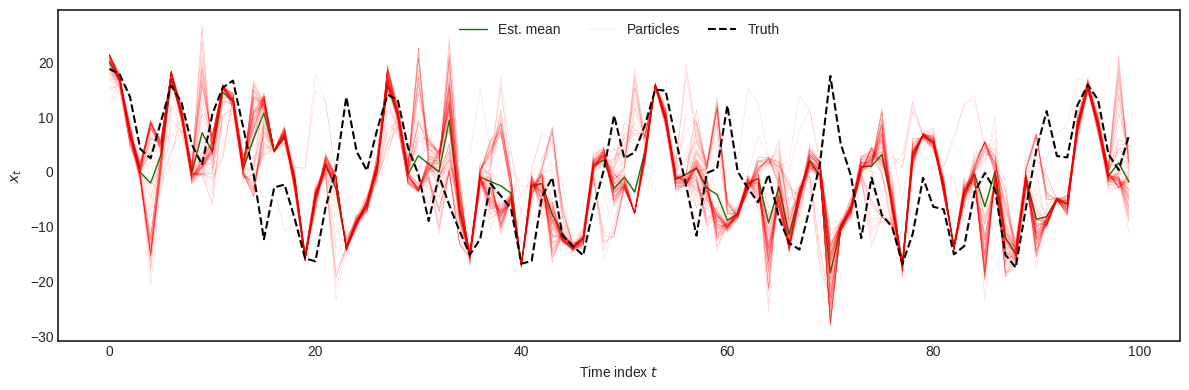

In [11]:
fig, axes = plot_results(results_etkf, observation_time_indices, state_sequence)

### Bootstrap particle filter

In [12]:
bspf = filters.BootstrapParticleFilter()

In [13]:
results_bspf = bspf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=500, rng=rng, return_particles=True)

Filtering: 100%|██████████|100/100 [00:00<00:00, 3062.47time-steps/s]

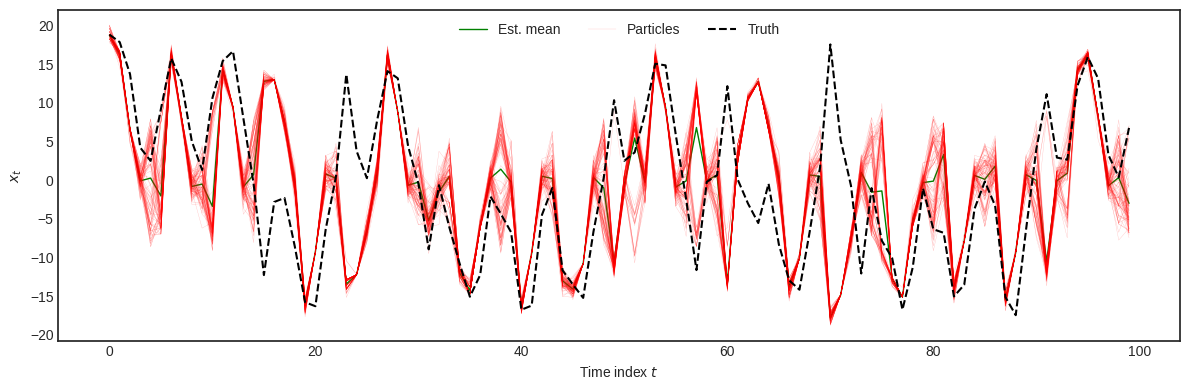

In [14]:
fig, axes = plot_results(results_bspf, observation_time_indices, state_sequence)

### Ensemble transform particle filter

In [15]:
etpf = filters.EnsembleTransformParticleFilter()

In [16]:
results_etpf = etpf.filter(
    model, observation_sequence, observation_time_indices, 
    num_particle=500, rng=rng, return_particles=True)

Filtering: 100%|██████████|100/100 [00:02<00:00, 41.33time-steps/s]

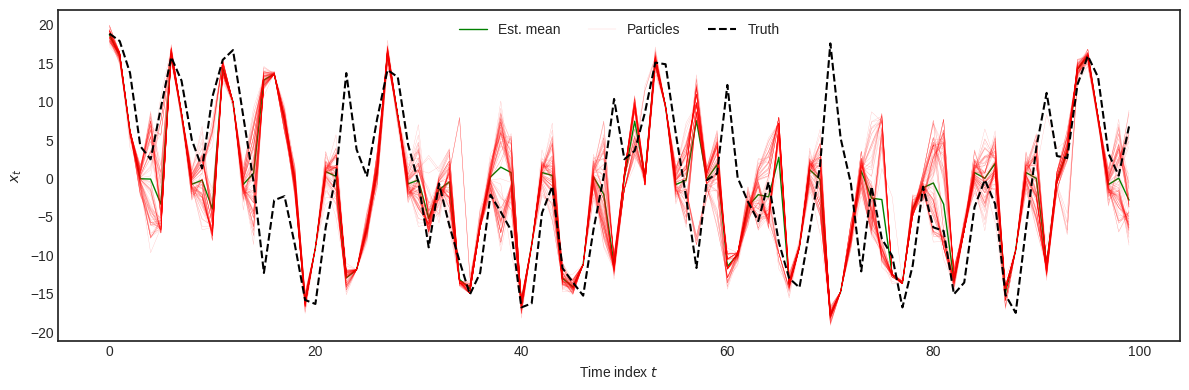

In [17]:
fig, axes = plot_results(results_etpf, observation_time_indices, state_sequence)